# Binary Feed-Forward Neural Net Function in Tensorflow
## Animated Training Progress

##### Import Packages

In [1]:
import pickle as pkl, tensorflow as tf, pandas as pd, numpy as np
import itertools, random, time, datetime, gc, math, numbers
from random import choices
from functools import partial
from operator import itemgetter
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib notebook
import matplotlib.pyplot as plt

##### Define Functions

In [5]:
def titanic_proc(csv_path, train_test, cv_split = False, test_perc = 0.2):
    """import and process titanic example dataset"""
    if train_test == 'train':
        df = pd.read_csv(csv_path,
                     usecols = ['Survived', 'Pclass', 'Sex', 'Age',
                                'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'])
        output = pd.concat([df['Survived'],
                           pd.get_dummies(df['Pclass'], drop_first = True, prefix = 'Pclass'),
                           pd.get_dummies(df['Sex'], drop_first = True, prefix = 'Sex'),
                           df[['Age']].fillna(0),
                           pd.get_dummies(df['SibSp'], drop_first = True, prefix = 'SibSp'),
                           pd.get_dummies(df['Parch'], drop_first = True,  prefix = 'Parch'),
                           df[['Fare']].fillna(0),
                           pd.DataFrame({'Parch_9': [i * 0 for i in range(df.shape[0])]}),
                           pd.get_dummies(df['Embarked'], drop_first = True, prefix = 'Embarked')], axis = 1)
    else:
        df = pd.read_csv(csv_path,
                     usecols = ['Pclass', 'Sex', 'Age',
                                'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'])
        output = pd.concat([pd.get_dummies(df['Pclass'], drop_first = True, prefix = 'Pclass'),
                           pd.get_dummies(df['Sex'], drop_first = True, prefix = 'Sex'),
                           df[['Age']].fillna(0),
                           pd.get_dummies(df['SibSp'], drop_first = True, prefix = 'SibSp'),
                           pd.get_dummies(df['Parch'], drop_first = True,  prefix = 'Parch'),
                           df[['Fare']].fillna(0),
                           pd.get_dummies(df['Embarked'], drop_first = True, prefix = 'Embarked')], axis = 1)
        
    if cv_split:
        output1, output2 = train_test_split(output, test_size=test_perc)
        return output1, output2
    else:
        return output

def seconds_to_time(sec):
    """converts seconds to hh:mm:ss format"""
    if (sec // 3600) == 0:
        HH = '00'
    elif (sec // 3600) < 10:
        HH = '0' + str(int(sec // 3600))
    else:
        HH = str(int(sec // 3600))
    min_raw = (np.float64(sec) - (np.float64(sec // 3600) * 3600)) // 60
    if min_raw < 10:
        MM = '0' + str(int(min_raw))
    else:
        MM = str(int(min_raw))
    sec_raw = (sec - (np.float64(sec // 60) * 60))
    if sec_raw < 10:
        SS = '0' + str(int(sec_raw))
    else:
        SS = str(int(sec_raw))
    return HH + ':' + MM + ':' + SS + ' (hh:mm:ss)'

def pandas_dec_to_float(dat, id_cols):
    """converts decimal columns to float excl. 'id_cols"""
    start_tm = time.time()
    dec_cols = []
    for c in dat.columns:
        if c in id_cols:
            pass
        elif dat[c].dtype == 'object':
            dec_cols.append(c)
        else:
            pass
    for dc in dec_cols:
        dat[dc] = dat[dc].astype(float)
        dat[dc].fillna(0, inplace = True)
    end_tm = time.time()
    sec_elapsed = (np.float64(end_tm) - np.float64(start_tm))
    print('Execution Time: ' + seconds_to_time(sec_elapsed))

def slice_by_index(lst, indexes):
    """subset list with another list (of indices)"""
    if not lst or not indexes:
        return []
    slice_ = itemgetter(*indexes)(lst)
    if len(indexes) == 1:
        return [slice_]
    return list(slice_)

def shuffle_batch(y, batch_size):
    """create list of batch indices"""
    rnd_idx = np.random.permutation(len(y))
    n_batches = len(y) // batch_size
    batch_list = []
    for batch_idx in np.array_split(rnd_idx, n_batches):
        batch_list.append([x for x in batch_idx])
    return batch_list

def fwd_net(trn_x, val_x, tst_x, trn_y, val_y,
            init_learn_rate = 0.01,
            num_neurons = [160,160],
            dropout_rates = [0.2,0.2],
            use_batchnorm = [0,0],
            num_layers = 2,
            reg_constant = 0.0001,
            num_epochs = 200,
            early_stop = 25,
            batch_size = 300,
            save_path_name = 'C:/your_directory/your_folder/',
            show_progress = 'animate'):
    ### Scale Input Data ###
    start_tm = time.time()
    scaler = StandardScaler()
    Train_X = pd.DataFrame(scaler.fit_transform(trn_x),
                           index = trn_x.index,
                           columns = trn_x.columns).astype(np.float32)
    Valid_X = pd.DataFrame(scaler.fit_transform(val_x),
                           index = val_x.index,
                           columns = val_x.columns).astype(np.float32)
    Test_X = pd.DataFrame(scaler.transform(tst_x),
                           index = tst_x.index,
                           columns = tst_x.columns).astype(np.float32)
    ### Reset Graph, Define Class Imbalance, Batches Indices, Placeholders ###
    tf.reset_default_graph()
    trn_pos_perc = sum(trn_y) / len(trn_y)
    batch_i = shuffle_batch(trn_y, batch_size)
    x = tf.placeholder(tf.float32, shape = (None, Train_X.shape[1]), name = 'x')
    y = tf.placeholder(tf.int64)
    he_init = tf.contrib.layers.variance_scaling_initializer()
    dense_layer = partial(tf.layers.dense, activation = tf.nn.relu, 
                          kernel_initializer = he_init,
                          kernel_regularizer = tf.contrib.layers.l1_regularizer(reg_constant))
    training = tf.placeholder_with_default(False, shape = (), name = 'training')
    bnorm_layer = partial(tf.layers.batch_normalization, training = training, momentum = 0.9)
    ### Define Network Topology Based on Dropout, Batch Norm, & No. Layer Configuration ###
    with tf.name_scope('dnn'):
        if len(num_neurons) == 1:
            h1 = dense_layer(x, num_neurons[0], name = 'h1')
            if use_batchnorm[0] == 1:
                b1 = bnorm_layer(h1)
                d1 = tf.layers.dropout(b1, rate = dropout_rates[0])
            else:
                d1 = tf.layers.dropout(h1, rate = dropout_rates[0])
            logits = tf.layers.dense(d1, 2, activation = None, name = 'outputs')
            y_prob = tf.nn.softmax(logits)
        elif len(num_neurons) == 2:
            h1 = dense_layer(x, num_neurons[0], name = 'h1')
            if use_batchnorm[0] == 1:
                b1 = bnorm_layer(h1)
                d1 = tf.layers.dropout(b1, rate = dropout_rates[0])
            else:
                d1 = tf.layers.dropout(h1, rate = dropout_rates[0])
            h2 = dense_layer(d1, num_neurons[1], name = 'h2')
            if use_batchnorm[1] == 1:
                b2 = bnorm_layer(h2)
                d2 = tf.layers.dropout(b2, rate = dropout_rates[1])
            else:
                d2 = tf.layers.dropout(h2, rate = dropout_rates[1])
            logits = tf.layers.dense(d2, 2, activation = None, name = 'outputs')
            y_prob = tf.nn.softmax(logits)
        elif len(num_neurons) == 3:
            h1 = dense_layer(x, num_neurons[0], name = 'h1')
            if use_batchnorm[0] == 1:
                b1 = bnorm_layer(h1)
                d1 = tf.layers.dropout(b1, rate = dropout_rates[0])
            else:
                d1 = tf.layers.dropout(h1, rate = dropout_rates[0])
            h2 = dense_layer(d1, num_neurons[1], name = 'h2')
            if use_batchnorm[1] == 1:
                b2 = bnorm_layer(h2)
                d2 = tf.layers.dropout(b2, rate = dropout_rates[1])
            else:
                d2 = tf.layers.dropout(h2, rate = dropout_rates[1])
            h3 = dense_layer(d2, num_neurons[2], name = 'h3')
            if use_batchnorm[2] == 1:
                b3 = bnorm_layer(h3)
                d3 = tf.layers.dropout(b3, rate = dropout_rates[2])
            else:
                d3 = tf.layers.dropout(h3, rate = dropout_rates[2])
            logits = tf.layers.dense(d3, 2, activation = None, name = 'outputs')
            y_prob = tf.nn.softmax(logits)
        else:
            print("number of hidden layers should be 1, 2, or 3")
    ### Loss Function - Adjusted by Inverse Class Weights ###
    with tf.name_scope('loss'):
        class_weights = tf.constant([trn_pos_perc, (1 - trn_pos_perc)])
        weights = tf.gather(class_weights, y)
        base_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels = y, logits = logits, weights = weights))
        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add(base_loss, reg_constant * sum(reg_losses), name = 'loss')
    ### Optimization Algorithm ###
    with tf.name_scope('train'):
        optimizer = tf.train.GradientDescentOptimizer(init_learn_rate)
        training_op = optimizer.minimize(loss)
    ### Evaluation ###
    with tf.name_scope('eval'):
        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        pred_prob = tf.nn.softmax(logits, name = 'pred_prob')
    ### Training ###
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        init.run()
        best_loss = 9999999
        loss_list = []; trn_loss_list = []
        break_list = []; save_ind_list = []
        if show_progress == 'animate':
            fig = plt.figure()
            ax = fig.add_subplot(111)
            plt.ion()
            fig.show()
            fig.canvas.draw()
        else:
            pass
        for epoch in range(num_epochs):
            for b in range(0, len(batch_i)):
                batch_x = Train_X.iloc[batch_i[b],:]
                batch_y = slice_by_index(trn_y, batch_i[b])
                sess.run(training_op, feed_dict = {x: batch_x, y: batch_y})
            ### Record Evaluation ###
            loss_val, acc_val = sess.run([loss, accuracy], feed_dict = {x: Valid_X, y: val_y})
            loss_trn, acc_trn = sess.run([loss, accuracy], feed_dict = {x: Train_X, y: trn_y})
            loss_list.append(np.round(loss_val, 6))
            trn_loss_list.append(np.round(loss_trn, 6))
            ### Display Training Progress ###
            if show_progress == 'print':
                print('Epoch ', f'{epoch:03}', ' Loss [Train, Val]: ',
                      str("%.6f" % np.round(loss_trn,6)), ', ',
                      str("%.6f" % np.round(loss_val,6)))
            elif show_progress == 'animate':
                trn_prog = pd.DataFrame({'Epoch': [i for i in range(1, len(loss_list) + 1, 1)],
                                         'Train Error': trn_loss_list,
                                         'Validation Error': loss_list})
                ax.clear()
                ax.plot([x for x in trn_prog['Epoch']], [y for y in trn_prog['Train Error']],
                        marker = '.', ls = '', label = 'Train')
                ax.plot([x for x in trn_prog['Epoch']], [y for y in trn_prog['Validation Error']],
                        marker = '.', ls = '', label = 'Validation')
                ax.set_xlim([1, num_epochs + 1])
                plt.legend(loc=2)
                fig.canvas.draw()
            else:
                pass
            ### Early Stopping ###
            best_loss = min(loss_list)
            if loss_val > best_loss:
                break_list.append(1)
            else:
                break_list = []
                saver.save(sess, save_path_name)
            if sum(break_list) >= early_stop:
                print('Stopping after ' + str(epoch) + ' epochs\n\n')
                break
        with tf.Session() as sess:
            saver.restore(sess, save_path_name)
            pred_prob_array = pred_prob.eval(feed_dict = {x: Test_X})
            pred_probability = [p for p in pred_prob_array[:,1]]
            output_df = pd.DataFrame({'pred_y': pred_probability})
        end_tm = time.time()
        sec_elapsed = (np.float64(end_tm) - np.float64(start_tm))
        print('\n\nExecution Time: ' + seconds_to_time(sec_elapsed))
        return output_df

##### Read and Process Data

In [3]:
train, valid = titanic_proc(csv_path = 'C:/Users/user/Desktop/titanic/train.csv', train_test = 'train', cv_split = True)
test = titanic_proc(csv_path = 'C:/Users/user/Desktop/titanic/test.csv', train_test = 'test')

##### show_progress = 'animate'

<IPython.core.display.Javascript object>


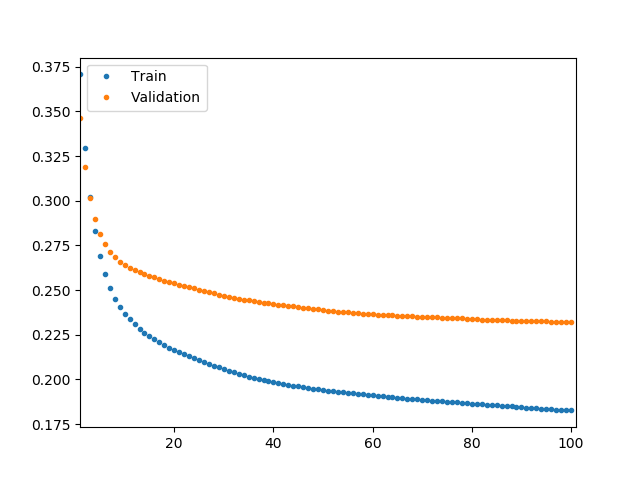

INFO:tensorflow:Restoring parameters from C:/Users/user/Desktop/tf_classif_save/


Execution Time: 00:00:20 (hh:mm:ss)


In [6]:
fit_nn = fwd_net(trn_x = train.drop('Survived', axis = 1),
                 val_x = valid.drop('Survived', axis = 1),
                 tst_x = test,
                 trn_y = [i for i in train['Survived']],
                 val_y = [i for i in valid['Survived']],
                 init_learn_rate = 0.01,
                 num_neurons = [20,20],
                 dropout_rates = [0.2,0.2],
                 use_batchnorm = [1,1],
                 num_layers = 2,
                 reg_constant = 0.0001,
                 num_epochs = 100,
                 early_stop = 15,
                 batch_size = 20,
                 save_path_name = 'C:/Users/user/Desktop/tf_classif_save/',
                 show_progress = 'animate')

##### show_progress = 'print'

In [7]:
fit_nn = fwd_net(trn_x = train.drop('Survived', axis = 1),
                 val_x = valid.drop('Survived', axis = 1),
                 tst_x = test,
                 trn_y = [i for i in train['Survived']],
                 val_y = [i for i in valid['Survived']],
                 init_learn_rate = 0.01,
                 num_neurons = [20,20],
                 dropout_rates = [0.2,0.2],
                 use_batchnorm = [1,1],
                 num_layers = 2,
                 reg_constant = 0.0001,
                 num_epochs = 100,
                 early_stop = 15,
                 batch_size = 20,
                 save_path_name = 'C:/Users/user/Desktop/tf_classif_save/',
                 show_progress = 'print')

Epoch  000  Loss [Train, Val]:  0.356567 ,  0.373808
Epoch  001  Loss [Train, Val]:  0.332919 ,  0.354378
Epoch  002  Loss [Train, Val]:  0.316877 ,  0.341056
Epoch  003  Loss [Train, Val]:  0.304566 ,  0.330660
Epoch  004  Loss [Train, Val]:  0.295051 ,  0.322273
Epoch  005  Loss [Train, Val]:  0.287300 ,  0.315160
Epoch  006  Loss [Train, Val]:  0.280900 ,  0.309162
Epoch  007  Loss [Train, Val]:  0.275436 ,  0.303980
Epoch  008  Loss [Train, Val]:  0.270631 ,  0.299355
Epoch  009  Loss [Train, Val]:  0.266357 ,  0.295195
Epoch  010  Loss [Train, Val]:  0.262580 ,  0.291493
Epoch  011  Loss [Train, Val]:  0.259205 ,  0.288123
Epoch  012  Loss [Train, Val]:  0.256134 ,  0.285014
Epoch  013  Loss [Train, Val]:  0.253330 ,  0.282143
Epoch  014  Loss [Train, Val]:  0.250716 ,  0.279460
Epoch  015  Loss [Train, Val]:  0.248271 ,  0.277011
Epoch  016  Loss [Train, Val]:  0.245977 ,  0.274717
Epoch  017  Loss [Train, Val]:  0.243715 ,  0.272534
Epoch  018  Loss [Train, Val]:  0.241445 ,  0.